In [1]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import torch

import numpy as np
import mpld3

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)       # can help with debugging
pyro.set_rng_seed(10)

In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)

def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot( y.numpy(), 'kx')
    if plot_predictions:
        Xtest = X  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot( mean.numpy(), 'r', lw=2)  # plot the mean
        plt.plot(  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-0.5, 5.5)

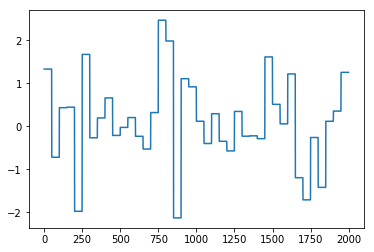

In [3]:
N = 2000
n_regresors = 5

N_repeated = 50

u = np.random.normal(0, 1., (np.int(N/N_repeated),n_regresors))
X = torch.tensor(np.repeat(u,N_repeated, axis=0), dtype=torch.float)  # Input vector
plt.plot(X[:,0].numpy())
N = X.shape[0]

In [4]:
Nr = 3
# X = dist.Normal(0.0, 5.0).sample(sample_shape=(int(N/10),Nr))

y = torch.zeros(N)
for i in range(1,N):
    y[i] = 0.5*y[i-1] + X[i,0]* torch.exp(0.1*X[i,1]) +  torch.sum(X[i,2:])
y = y+ dist.Normal(0.0, 0.1).sample(sample_shape=(N,))

plt.figure(figsize= (5,3))
plt.subplot(121)
plt.plot(y.numpy())
plt.subplot(122)
plt.plot(X.numpy())
# plt.show()
mpld3.display()

In [5]:
# def build_regressor(X, Y, n_lag = 1):
#     for i in range(n_lag):
#         torch.cat((X[0:10,:]. Y[])



In [6]:
N_learn = 500
Nlag = 2

X_learn = torch.cat((X[2:N_learn+2,:],y[0:N_learn].unsqueeze(1), y[1:N_learn+1].unsqueeze(1)),1)
Y_learn = y[2:N_learn+2]
Y_learn.shape

torch.Size([500])

In [7]:
kernel = gp.kernels.RBF(input_dim=n_regresors+Nlag, variance=torch.tensor(5.),
                        lengthscale=torch.tensor(10.))
gpr = gp.models.GPRegression(X_learn, Y_learn, kernel, noise=torch.tensor(1.))



In [8]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2500 if not smoke_test else 2
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

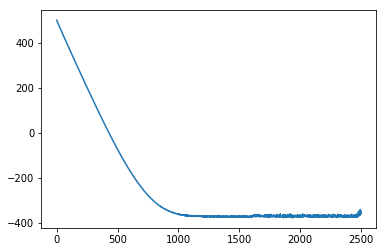

In [9]:
plt.plot(losses);

In [10]:
N_learn = N-2

Xtest = torch.cat((X[2:N_learn+2,:],y[0:N_learn].unsqueeze(1), y[1:N_learn+1].unsqueeze(1)),1)

Ytest = y[2:]
print(Xtest.shape)
print(Ytest.shape)

torch.Size([1998, 7])
torch.Size([1998])


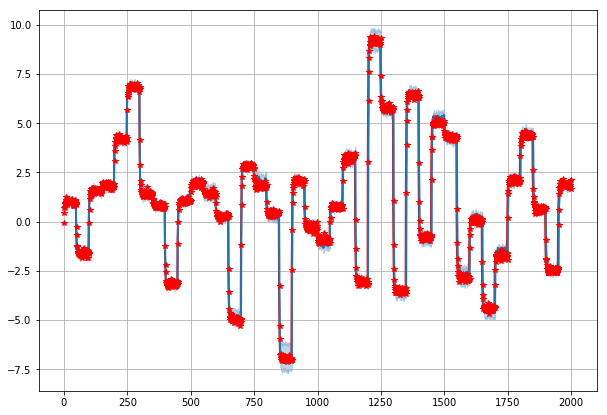

In [11]:
# compute predictive mean and variance

plt.figure(figsize=(10,7))
x_plot = np.linspace(0,N,N-Nlag)
model = gpr
with torch.no_grad():
    if type(model) == gp.models.VariationalSparseGP:
        mean, cov = model(Xtest, full_cov=True)
    else:
        mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot( mean.numpy(), 'r', lw=2)  # plot the mean
        
        plt.plot(x_plot, mean.numpy(), color='C0', lw=2)  # plot the mean
        plt.fill_between(x_plot,  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
#         plt.plot(  # plot the two-sigma uncertainty about the mean
#                 (mean - 2.0 * sd).numpy())
#         plt.plot((mean + 2.0 * sd).numpy())
        plt.plot(y.numpy(), 'r*')
    plt.grid()
        
# mpld3.display()

### Recurent Neural Network

Implementacija RNN

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

#### Prepare data


In [13]:
X = torch.cat((X[2:,:],y[0:-2].unsqueeze(1), y[1:-1].unsqueeze(1)),1)
Y = y[0:-2]
print(X.shape)
print(Y.shape)



torch.Size([1998, 7])
torch.Size([1998])


In [33]:
ntrain = 1000
num_x_signals = 7
num_y_signals = 1
x_scaler = MinMaxScaler()
X_learn_scaled = x_scaler.fit_transform(X[:ntrain,:])
X_test_scaled = x_scaler.fit_transform(X[ntrain:,:])

y_scaler = MinMaxScaler()
Y_learn_scaled = y_scaler.fit_transform(Y[:ntrain].reshape(-1, 1))
Y_test_scaled = y_scaler.fit_transform(Y[ntrain:].reshape(-1, 1))
num_train = Y_learn_scaled.shape[0]
print(Y_learn_scaled.shape)
print(Y_test_scaled.shape)

print(X_learn_scaled.shape)
print(X_test_scaled.shape)

(1000, 1)
(998, 1)
(1000, 7)
(998, 7)


In [34]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_learn_scaled[idx:idx+sequence_length]
            y_batch[i] = Y_learn_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [46]:
batch_size = 300
sequence_length = 300

generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)

In [47]:
print(x_batch.shape)
print(y_batch.shape)

(300, 300, 7)
(300, 300, 1)


In [48]:
warmup_steps = 50

In [52]:


model = Sequential()
model.add(LSTM(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))
validation_data = (np.expand_dims(X_test_scaled, axis=0),
                   np.expand_dims(Y_test_scaled, axis=0))

In [53]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [54]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [55]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 256)         270336    
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           257       
Total params: 270,593
Trainable params: 270,593
Non-trainable params: 0
_________________________________________________________________


In [56]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [57]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [58]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [59]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 0s 199ms/sample - loss: 0.0097

Epoch 00001: val_loss improved from inf to 0.00974, saving model to 23_checkpoint.keras
100/100 [==============================] - 119s 1s/step - loss: 0.0141 - val_loss: 0.0097
Epoch 2/20
1/1 [==============================] - 0s 142ms/sample - loss: 0.0050

Epoch 00002: val_loss improved from 0.00974 to 0.00498, saving model to 23_checkpoint.keras
100/100 [==============================] - 121s 1s/step - loss: 0.0038 - val_loss: 0.0050
Epoch 3/20
1/1 [==============================] - 0s 134ms/sample - loss: 0.0044

Epoch 00003: val_loss improved from 0.00498 to 0.00440, saving model to 23_checkpoint.keras
100/100 [==============================] - 124s 1s/step - loss: 0.0018 - val_loss: 0.0044
Epoch 4/20
1/1 [==============================] - 0s 129ms/sample - loss: 0.0055

Epoch 00004: val_loss did not improve from 0.00440

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001000000047497451

In [60]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [61]:
result = model.evaluate(x=np.expand_dims(X_test_scaled, axis=0),
                        y=np.expand_dims(Y_test_scaled, axis=0))

1/1 [==============================] - 0s 133ms/sample - loss: 0.0024


In [62]:
target_names = 'Y'

In [63]:
def plot_comparison(start_idx, length=1998, train=False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_learn_scaled
        y_true = Y[:ntrain].numpy().reshape(-1, 1)
    else:
        # Use test-data.
        x = X_test_scaled
        y_true = Y[ntrain:].numpy().reshape(-1, 1)
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()
    return signal_pred, signal_true

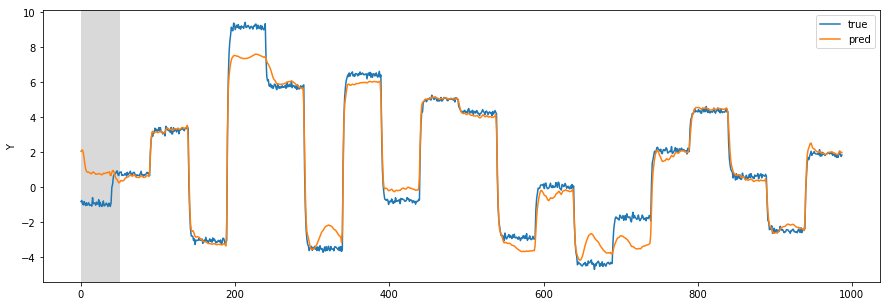

In [64]:
y_RNN, yt = plot_comparison(start_idx=10, length=1998, train=False)

In [65]:
plt.figure(figsize=(10,5))
plt.plot(y_RNN, label='RNN')
plt.plot(mean.numpy()[ntrain:], label='GP')
plt.plot(Y.numpy()[ntrain:], '+', label='Truth')
plt.legend()
mpld3.display()
